In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import DBSCAN 


In [4]:
# Load the datasets
google_ads_df = pd.read_csv('googlead-performance.csv')
meta_ads_df = pd.read_csv('metaads-performance.csv')
microsoft_ads_df = pd.read_csv('microsoftads-performance.csv')
website_landings_df = pd.read_csv('website-landings.csv')


In [5]:
print(google_ads_df.head())

         Date    Campaign type  Impressions  Clicks    Cost  Conversions  \
0  2024-01-01    Cross-network     216382.0  2765.0  1957.4        136.1   
1  2024-01-01  Display Network       3873.0    85.0    27.2          1.0   
2  2024-01-01   Search Network       6856.0   753.0   917.3         54.7   
3  2024-01-02    Cross-network     236636.0  2750.0  2055.9        148.9   
4  2024-01-02  Display Network       5030.0    96.0    26.7          0.8   

   Revenue  
0  17835.5  
1     84.6  
2   8777.1  
3  19639.5  
4     91.2  


In [6]:
print(meta_ads_df.head())

         Date  Impressions   Reach  Cost  Clicks  Conversions  Revenue
0  2024-01-01      11560.0  7851.0  66.5   415.0          8.0   2258.3
1  2024-01-02       9674.0  6278.0  64.3   320.0         11.0   1894.2
2  2024-01-03       8640.0  5414.0  63.4   276.0         12.0   1808.1
3  2024-01-04       9057.0  5798.0  62.6   309.0          6.0   1962.0
4  2024-01-05       9448.0  6120.0  61.7   282.0          8.0   1763.5


In [7]:
print(microsoft_ads_df.head())

         Date     Campaign type  Impressions  Clicks   Cost  Conversions  \
0  2024-01-01  Search & content        831.0   100.0  108.6         15.0   
1  2024-01-01          Shopping      20128.0   316.0  149.0         13.0   
2  2024-01-02  Search & content       1069.0   163.0  188.4         26.0   
3  2024-01-02          Shopping      31540.0   366.0  166.9         11.0   
4  2024-01-03  Search & content        960.0   153.0  180.7         22.0   

   Revenue  
0   2240.6  
1   2364.3  
2   4383.0  
3    423.6  
4   3035.6  


In [8]:
print(website_landings_df.head())

    User Id Website Landing Time  Is Converted  Source         Channel  \
0  f7093a95  2024-02-02 01:19:03             0  google  organic search   
1  f7093a95  2024-02-20 17:53:27             0  google  organic search   
2  f7093a95  2024-03-03 04:51:34             0  google  organic search   
3  f7093a95  2024-04-23 04:28:26             0     NaN          direct   
4  f7093a95  2024-04-23 04:29:56             0     NaN          direct   

  Campaign Type  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


In [9]:
# Convert date columns to datetime
google_ads_df['Date'] = pd.to_datetime(google_ads_df['Date'])
meta_ads_df['Date'] = pd.to_datetime(meta_ads_df['Date'])
microsoft_ads_df['Date'] = pd.to_datetime(microsoft_ads_df['Date'])
website_landings_df['Website Landing Time'] = pd.to_datetime(website_landings_df['Website Landing Time'])

In [10]:
google_ads_df.fillna(0, inplace=True)
meta_ads_df.fillna(0, inplace=True)
microsoft_ads_df.fillna(0, inplace=True)
website_landings_df.fillna(0, inplace=True)

In [11]:
google_ads_df['CTR'] = google_ads_df['Clicks'] / google_ads_df['Impressions']
google_ads_df['CPC'] = google_ads_df['Cost'] / google_ads_df['Clicks'].replace(0, np.nan)  # Handle division by zero

meta_ads_df['CTR'] = meta_ads_df['Clicks'] / meta_ads_df['Impressions']
meta_ads_df['CPC'] = meta_ads_df['Cost'] / meta_ads_df['Clicks'].replace(0, np.nan)  # Handle division by zero

microsoft_ads_df['CTR'] = microsoft_ads_df['Clicks'] / microsoft_ads_df['Impressions']
microsoft_ads_df['CPC'] = microsoft_ads_df['Cost'] / microsoft_ads_df['Clicks'].replace(0, np.nan)  # Handle division by zero


In [12]:
# Group by the correct column names and aggregate the data
try:
    landing_agg = website_landings_df.groupby(['Source', 'Channel', 'Campaign Type']).agg({
        'User Id': 'count',
        'Is Converted': 'sum'
    }).reset_index().rename(columns={'User Id': 'Total Landings', 'Is Converted': 'Total Conversions'})

    print("\nAggregated Website Landings Data:")
    print(landing_agg.head())
except KeyError as e:
    print(f"KeyError: {e}. Please check the column names and update the code accordingly.")



Aggregated Website Landings Data:
  Source      Channel Campaign Type  Total Landings  Total Conversions
0      0       direct             0         1661350              32602
1      0        email             0           23775                345
2      0  paid search             0               1                  0
3      0     referral             0           45152               1070
4      0       social             0               2                  0


In [13]:
print(website_landings_df.describe(include='all'))  # Summary statistics for all columns


         User Id           Website Landing Time  Is Converted     Source  \
count    2913111                        2913111  2.913111e+06  2913111.0   
unique   1811724                            NaN           NaN       35.0   
top     5cbc5066                            NaN           NaN        0.0   
freq        5262                            NaN           NaN  1730280.0   
mean         NaN  2024-03-31 04:06:15.874889984  2.072080e-02        NaN   
min          NaN            2024-01-01 00:00:25  0.000000e+00        NaN   
25%          NaN     2024-02-14 19:16:58.500000  0.000000e+00        NaN   
50%          NaN            2024-03-31 02:07:44  0.000000e+00        NaN   
75%          NaN     2024-05-12 10:14:10.500000  0.000000e+00        NaN   
max          NaN            2024-07-01 00:01:11  1.000000e+00        NaN   
std          NaN                            NaN  1.424481e-01        NaN   

        Channel  Campaign Type  
count   2913111      2913111.0  
unique        7      

In [14]:
# Convert 'Campaign Type' to string if it's categorical
website_landings_df['Campaign Type'] = website_landings_df['Campaign Type'].astype(str)

# Clean 'Source' column by removing or correcting placeholder values
website_landings_df['Source'] = website_landings_df['Source'].replace('0.0', np.nan)

# Drop rows where 'Source' or 'Campaign Type' is NaN if necessary
website_landings_df.dropna(subset=['Source', 'Campaign Type'], inplace=True)

# Recheck data types
print(website_landings_df.dtypes)

# Aggregate website landings data
landing_agg = website_landings_df.groupby(['Source', 'Channel', 'Campaign Type']).agg({
    'User Id': 'count',
    'Is Converted': 'sum'
}).reset_index().rename(columns={'User Id': 'Total Landings', 'Is Converted': 'Total Conversions'})

print("\nAggregated Website Landings Data:")
print(landing_agg.head())


User Id                         object
Website Landing Time    datetime64[ns]
Is Converted                     int64
Source                          object
Channel                         object
Campaign Type                   object
dtype: object

Aggregated Website Landings Data:
  Source      Channel Campaign Type  Total Landings  Total Conversions
0      0       direct             0         1661350              32602
1      0        email             0           23775                345
2      0  paid search             0               1                  0
3      0     referral             0           45152               1070
4      0       social             0               2                  0


In [15]:
print(website_landings_df.describe(include='all'))  # Summary statistics for all columns


         User Id           Website Landing Time  Is Converted     Source  \
count    2913111                        2913111  2.913111e+06  2913111.0   
unique   1811724                            NaN           NaN       35.0   
top     5cbc5066                            NaN           NaN        0.0   
freq        5262                            NaN           NaN  1730280.0   
mean         NaN  2024-03-31 04:06:15.874889984  2.072080e-02        NaN   
min          NaN            2024-01-01 00:00:25  0.000000e+00        NaN   
25%          NaN     2024-02-14 19:16:58.500000  0.000000e+00        NaN   
50%          NaN            2024-03-31 02:07:44  0.000000e+00        NaN   
75%          NaN     2024-05-12 10:14:10.500000  0.000000e+00        NaN   
max          NaN            2024-07-01 00:01:11  1.000000e+00        NaN   
std          NaN                            NaN  1.424481e-01        NaN   

        Channel Campaign Type  
count   2913111       2913111  
unique        7        

In [16]:
google_ads_df['CTR'] = google_ads_df['Clicks'] / google_ads_df['Impressions'] #Click through Rate
google_ads_df['CPC'] = google_ads_df['Cost'] / google_ads_df['Clicks']    #Cost Per Click

In [17]:
meta_ads_df['CTR'] = meta_ads_df['Clicks'] / meta_ads_df['Impressions']
meta_ads_df['CPC'] = meta_ads_df['Cost'] / meta_ads_df['Clicks']

microsoft_ads_df['CTR'] = microsoft_ads_df['Clicks'] / microsoft_ads_df['Impressions']
microsoft_ads_df['CPC'] = microsoft_ads_df['Cost'] / microsoft_ads_df['Clicks']


In [18]:
landing_agg = website_landings_df.groupby(['Source', 'Channel', 'Campaign Type']).agg({
    'User Id': 'count',
    'Is Converted': 'sum'
}).reset_index().rename(columns={'User Id': 'Total Landings', 'Is Converted': 'Total Conversions'})

In [19]:
print("\nAggregated Website Landings Data:")
print(landing_agg.head())



Aggregated Website Landings Data:
  Source      Channel Campaign Type  Total Landings  Total Conversions
0      0       direct             0         1661350              32602
1      0        email             0           23775                345
2      0  paid search             0               1                  0
3      0     referral             0           45152               1070
4      0       social             0               2                  0


In [20]:
features = ['Impressions', 'Clicks', 'Cost', 'CTR', 'CPC']
target = 'Conversions'

X = google_ads_df[features]
y = google_ads_df[target]


In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor

# Train your model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)



In [23]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print(f"Random Forest Model RMSE: {rmse:.2f}")
print(f"Random Forest Model MAE: {mae:.2f}")

Random Forest Model RMSE: 19.00
Random Forest Model MAE: 10.86


In [24]:
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")



Feature: Impressions, Importance: 0.1276
Feature: Clicks, Importance: 0.4922
Feature: Cost, Importance: 0.2525
Feature: CTR, Importance: 0.0198
Feature: CPC, Importance: 0.1080


In [25]:
# Customer Segmentation using KMeans
# kmeans = KMeans(n_clusters=5, random_state=42)
# website_landings_df['Cluster'] = kmeans.fit_predict(website_landings_df[['Is Converted']])
# Example of additional features
features = ['Is Converted', 'Source', 'Channel']  # Add more relevant features
X = pd.get_dummies(website_landings_df[features],drop_first=True)  # Convert categorical features to numerical

kmeans = KMeans(n_clusters=5, random_state=42)
website_landings_df['Cluster'] = kmeans.fit_predict(X)

print("\nCustomer Segmentation:")
print(website_landings_df.head())




Customer Segmentation:
    User Id Website Landing Time  Is Converted  Source         Channel  \
0  f7093a95  2024-02-02 01:19:03             0  google  organic search   
1  f7093a95  2024-02-20 17:53:27             0  google  organic search   
2  f7093a95  2024-03-03 04:51:34             0  google  organic search   
3  f7093a95  2024-04-23 04:28:26             0       0          direct   
4  f7093a95  2024-04-23 04:29:56             0       0          direct   

  Campaign Type  Cluster  
0             0        0  
1             0        0  
2             0        0  
3             0        1  
4             0        1  


In [26]:
# Check the number of data points in each cluster
cluster_counts = website_landings_df['Cluster'].value_counts()
print("\nCluster Sizes:")
print(cluster_counts)



Cluster Sizes:
Cluster
1    1739568
2     661620
3     229116
0     179591
4     103216
Name: count, dtype: int64


In [27]:
sample_df = website_landings_df.sample(frac=0.1, random_state=42)
X_sample = pd.get_dummies(sample_df[['Is Converted', 'Source', 'Channel']], drop_first=True)

In [29]:
# # # # Testing different number of clusters

# # # for n_clusters in range(2, 11):
# # #     kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
# # #     sample_df['Cluster'] = kmeans.fit_predict(sample_df[['Is Converted']])
# # #     silhouette_avg = silhouette_score(sample_df[['Is Converted']], sample_df['Cluster'])
# # #     print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}') 
# # for n_clusters in range(2, 11):
# #     kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)  # Adjust batch_size if needed
# #     sample_df['Cluster'] = kmeans.fit_predict(X_sample)
    
# #     # Calculate silhouette score only if more than 1 cluster is formed
# #     if len(set(sample_df['Cluster'])) > 1:
# #         silhouette_avg = silhouette_score(X_sample, sample_df['Cluster'])
# #         print(f'Number of clusters: {cluster_counts}, Silhouette Score: {silhouette_avg:.2f}')
# #     else:
# #         print(f'Number of clusters: {cluster_counts}, Silhouette Score: Not applicable (single cluster)')
# for n_clusters in range(2, 11):
#     kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
#     sample_df['Cluster'] = kmeans.fit_predict(X_sample)
#     inertia = kmeans.inertia_
#     print(f'Number of clusters: {n_clusters}, Inertia: {inertia:.2f}')


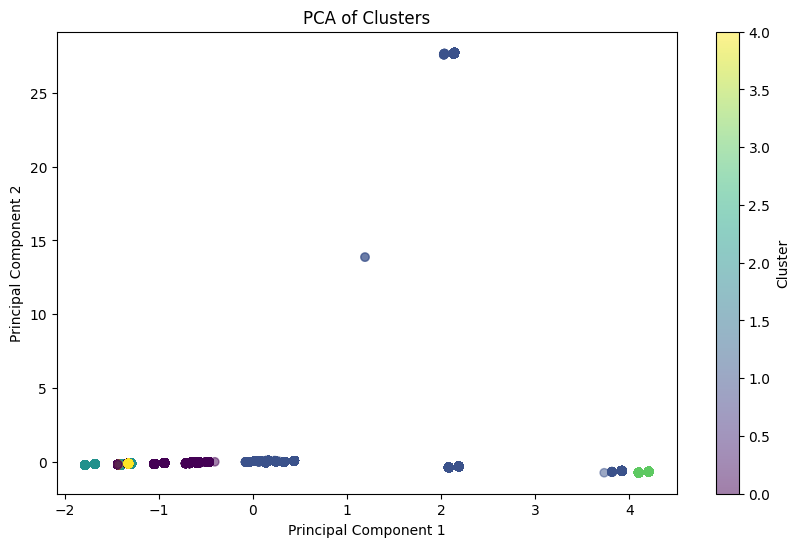

KeyboardInterrupt: 

In [32]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=website_landings_df['Cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Clusters')
plt.show()

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
website_landings_df['Cluster'] = dbscan.fit_predict(X)
cluster_counts_dbscan = website_landings_df['Cluster'].value_counts()
print("\nDBSCAN Cluster Sizes:")
print(cluster_counts_dbscan)

In [2]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
sample_df['Cluster'] = dbscan.fit_predict(X_pca)

# Check cluster sizes
cluster_counts_dbscan = sample_df['Cluster'].value_counts()
print("\nDBSCAN Cluster Sizes:")
print(cluster_counts_dbscan)

NameError: name 'DBSCAN' is not defined

In [ ]:
website_landings_df['Is Converted'].value_counts().plot(kind='bar')
plt.title('Distribution of Conversion Status')
plt.xlabel('Is Converted')
plt.ylabel('Count')
plt.show()


In [ ]:

cluster_counts = website_landings_df['Cluster'].value_counts()
print("\nCluster Sizes:")
print(cluster_counts)


In [ ]:
print(google_ads_df.head())